In [1]:
import os
import glob
import time
import joblib
import anndata
import numpy as np
import pandas as pd
import pynndescent
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'
from ALLCools.plot import *
from ALLCools.integration import confusion_matrix_clustering
from wmb import brain
from sklearn.preprocessing import OneHotEncoder, normalize



In [2]:
group_name = ''


In [3]:
# adata_merge = anndata.read_h5ad('/home/jzhou_salk_edu/sky_workdir/merfish_integration/merfish_integration_rna/L1/All/All_4533606_aibs10xmerfish.h5ad')
adata_merge = anndata.read_h5ad('aibs10xmerfish.h5ad')
adata_merge


AnnData object with n_obs × n_vars = 4678380 × 1
    obs: 'count', 'umi_count', 'L1', 'L2', 'L3', 'L1_annot', 'L2_annot', 'DissectionRegion', 'SubRegion', 'MajorRegion', 'Train', 'Study', 'blank_count', 'n_counts', 'n_genes', 'tsne_0', 'tsne_1', 'leiden'
    uns: 'leiden', 'neighbors'
    obsm: 'X_pca_corrected', 'X_tsne', 'u50seurat_tsne'
    obsp: 'connectivities', 'distances'

In [4]:
ds = min(10000/adata_merge.shape[0], 4)
count = adata_merge.obs['Study'].value_counts()
r = min(5, count['AIBS_10x'] / count['MERFISH'])
coord_base = "tsne"


(-20.738047245440743, 18.888916206531206)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


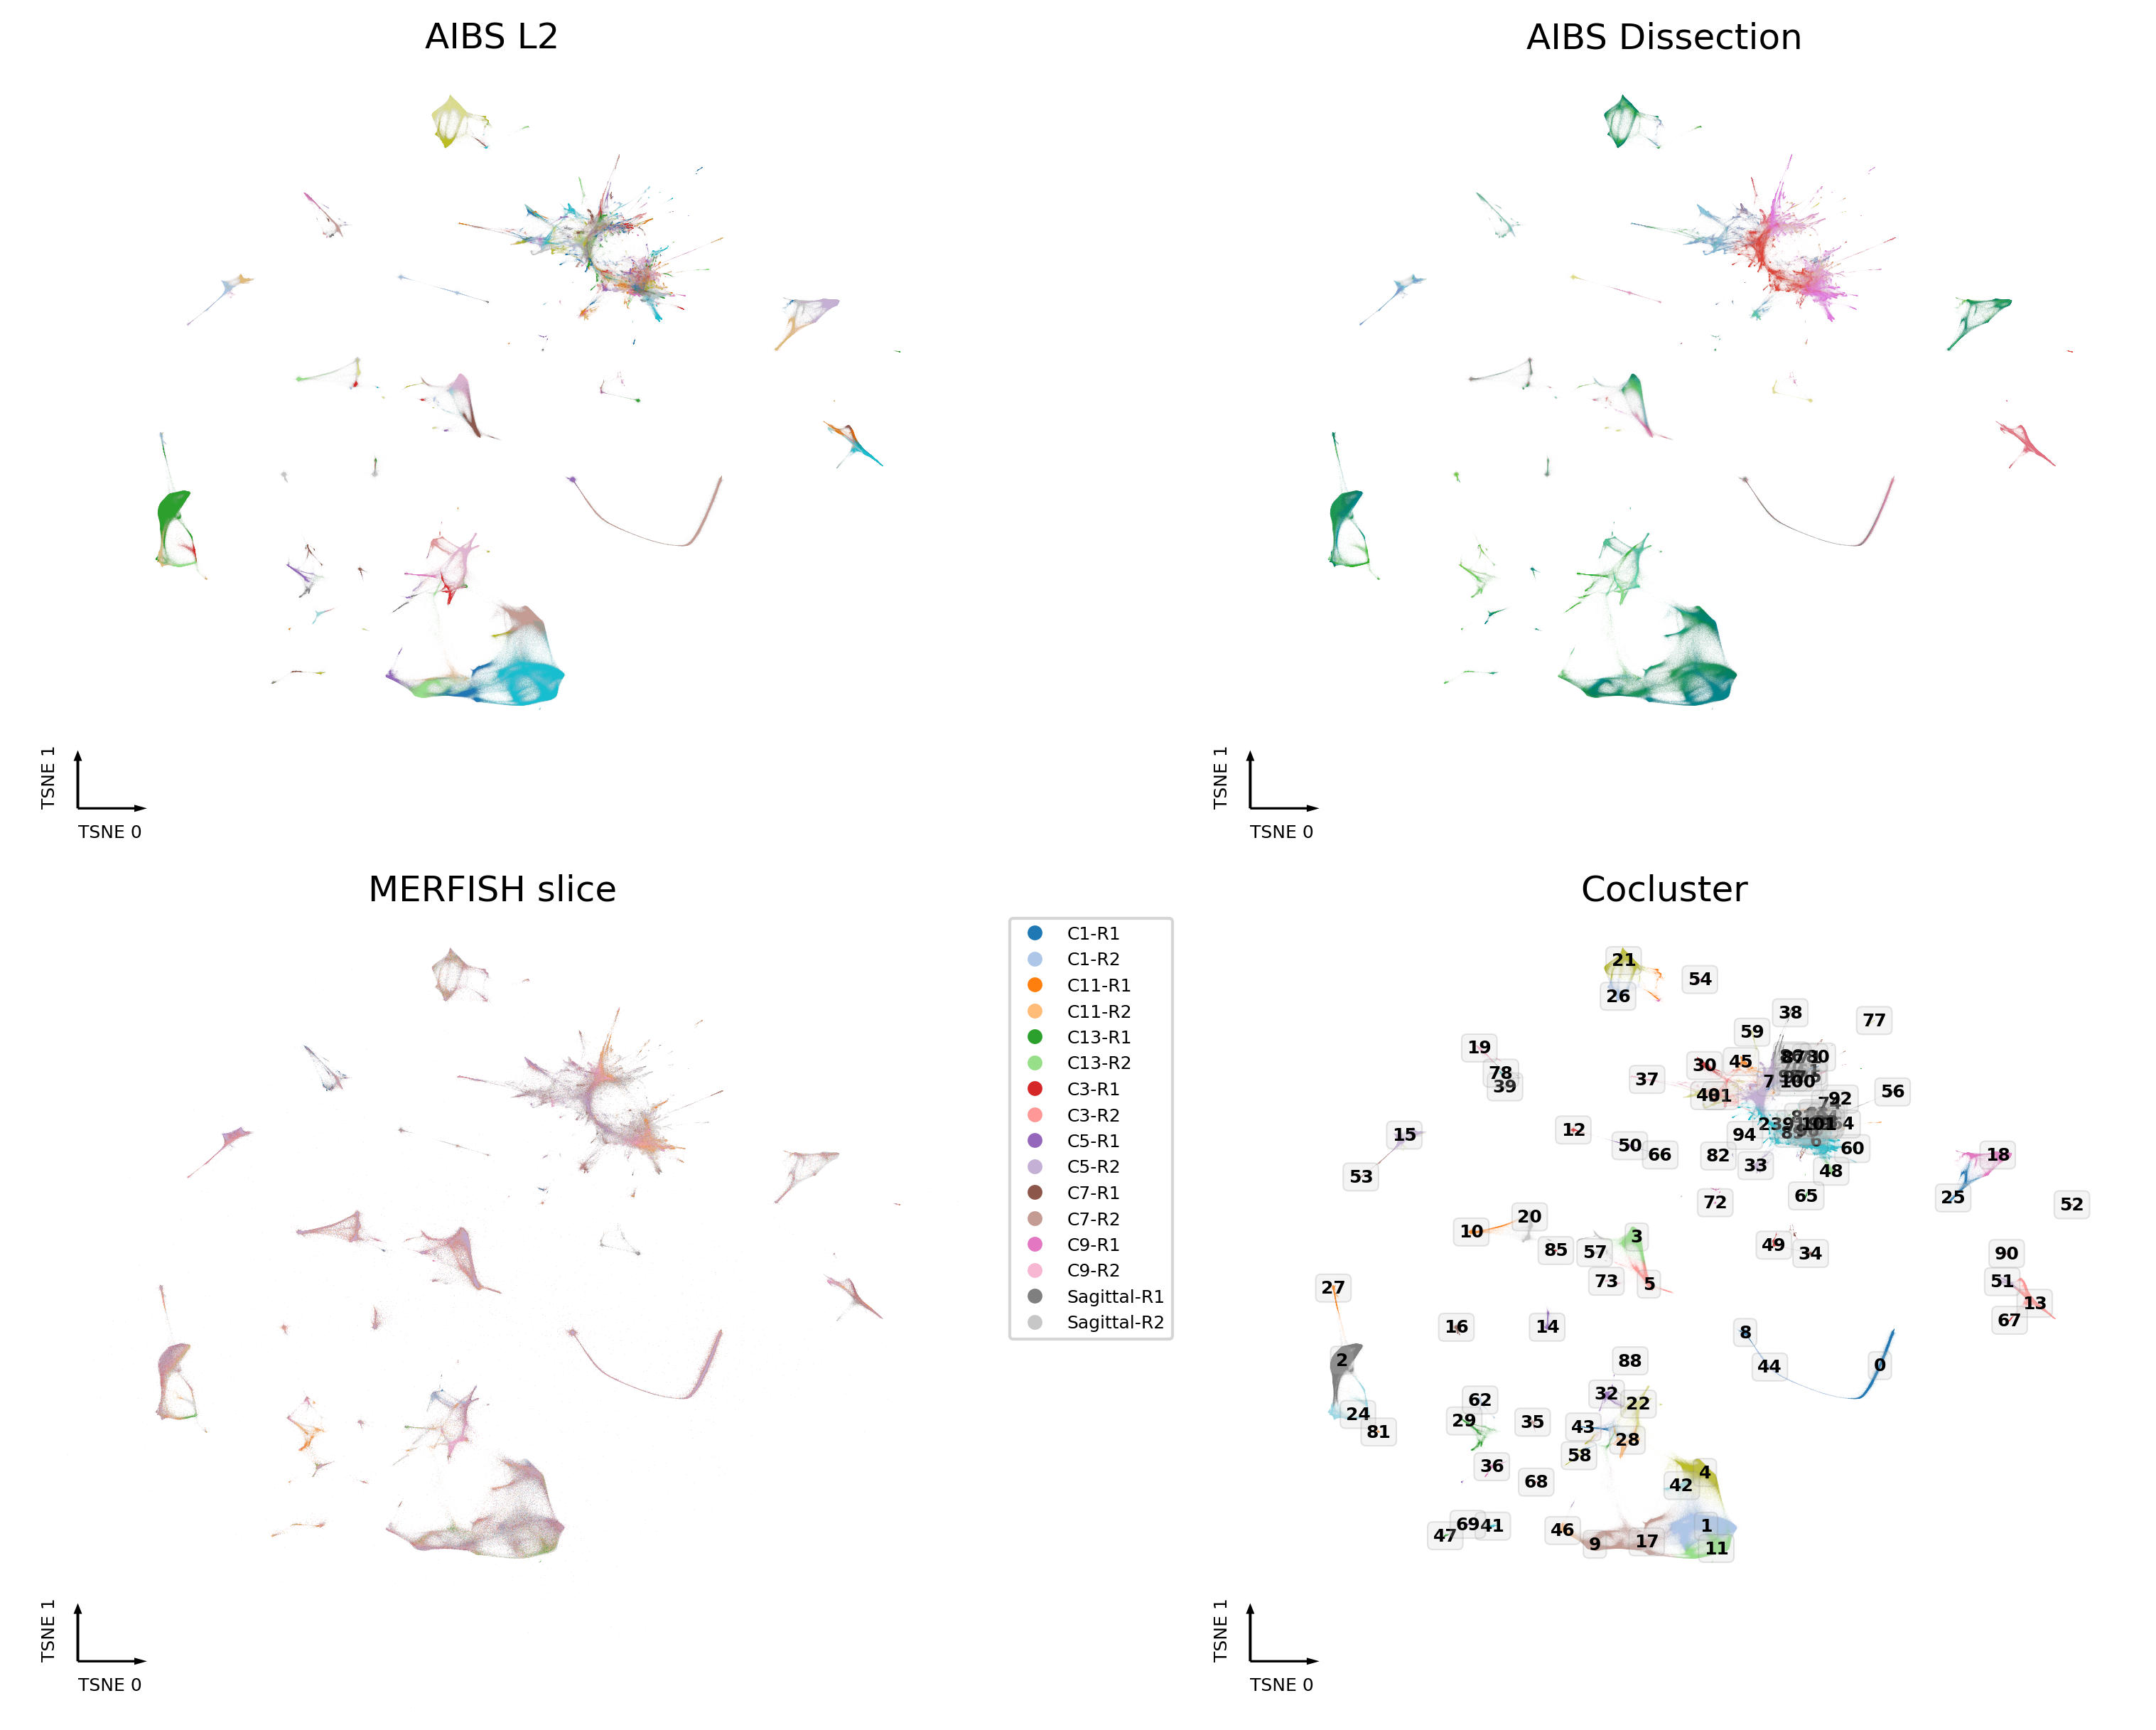

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), dpi=300, constrained_layout=True, sharex='all', sharey='all')

tmp = adata_merge.obs.loc[adata_merge.obs['Study']=='AIBS_10x']
# count = tmp['L1_annot_AIBS'].value_counts()
# tmp = tmp[tmp['L1_annot_AIBS'].isin(count.index[count>20])]
ax = axes[0,0]
ax.scatter(adata_merge.obs[f'{coord_base}_0'], adata_merge.obs[f'{coord_base}_1'], c='#e0e0e0', edgecolors='none', s=ds, rasterized=True)
_ = categorical_scatter(data=tmp,
                        ax=ax,
                        coord_base=coord_base,
                        s=ds,
                        hue='L2',
                        # text_anno='L3',
                        palette='tab20',
                        labelsize=6,
                        max_points=None,
                        scatter_kws={'rasterized':True},
                        #show_legend=True,
                        #legend_kws={'ncol':1},
                       )

ax = axes[0,1]
ax.scatter(adata_merge.obs[f'{coord_base}_0'], adata_merge.obs[f'{coord_base}_1'], c='#e0e0e0', edgecolors='none', s=ds, rasterized=True)
_ = categorical_scatter(data=tmp,
                        ax=ax,
                        coord_base=coord_base,
                        s=ds,
                        hue='DissectionRegion',
                        # text_anno='L1_annot',
                        palette=brain.get_dissection_region_palette(),
                        labelsize=6,
                        max_points=None,
                        scatter_kws={'rasterized':True},
                        #show_legend=True,
                        #legend_kws={'ncol':1},
                       )

tmp = adata_merge.obs.loc[adata_merge.obs['Study']=='MERFISH']
tmp['batch'] = [f'{"-".join(xx.split("-")[:2])}' for xx in tmp.index]
ax = axes[1,0]
ax.scatter(adata_merge.obs[f'{coord_base}_0'], adata_merge.obs[f'{coord_base}_1'], c='#e0e0e0', edgecolors='none', s=ds, rasterized=True)
_ = categorical_scatter(data=tmp,
                        ax=ax,
                        coord_base=coord_base,
                        s=ds*r,
                        hue='batch',
                        # text_anno='batch',
                        palette='tab20',
                        labelsize=6,
                        max_points=None,
                        scatter_kws={'rasterized':True},
                        show_legend=True,
                        legend_kws={'ncol':1},
                       )

ax = axes[1,1]
_ = categorical_scatter(data=adata_merge.obs,
                        ax=ax,
                        coord_base=coord_base,
                        s=ds,
                        hue='leiden',
                        text_anno='leiden',
                        palette='tab20',
                        labelsize=6,
                        max_points=None,
                        scatter_kws={'rasterized':True},
                        #show_legend=True,
                        #legend_kws={'ncol':1},
                       )

for i,xx in enumerate(['AIBS L2', 'AIBS Dissection', 'MERFISH slice', 'Cocluster']):
    axes.flatten()[i].set_title(xx, fontsize=12)

ax.set_xlim(adata_merge.obs[f'{coord_base}_0'].min(), adata_merge.obs[f'{coord_base}_0'].max())
ax.set_ylim(adata_merge.obs[f'{coord_base}_1'].min(), adata_merge.obs[f'{coord_base}_1'].max())


# plt.savefig(f'/gale/netapp/entex/CEMBA_RS2/RS1/plot/cell_{adata_merge.shape[0]}_Neu_10xAIBS2geneCH.pdf', transparent=True)




In [6]:
count = tmp["L2_annot"].value_counts()
leg = np.sort(count.index)


(-20.738047245440743, 18.888916206531206)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


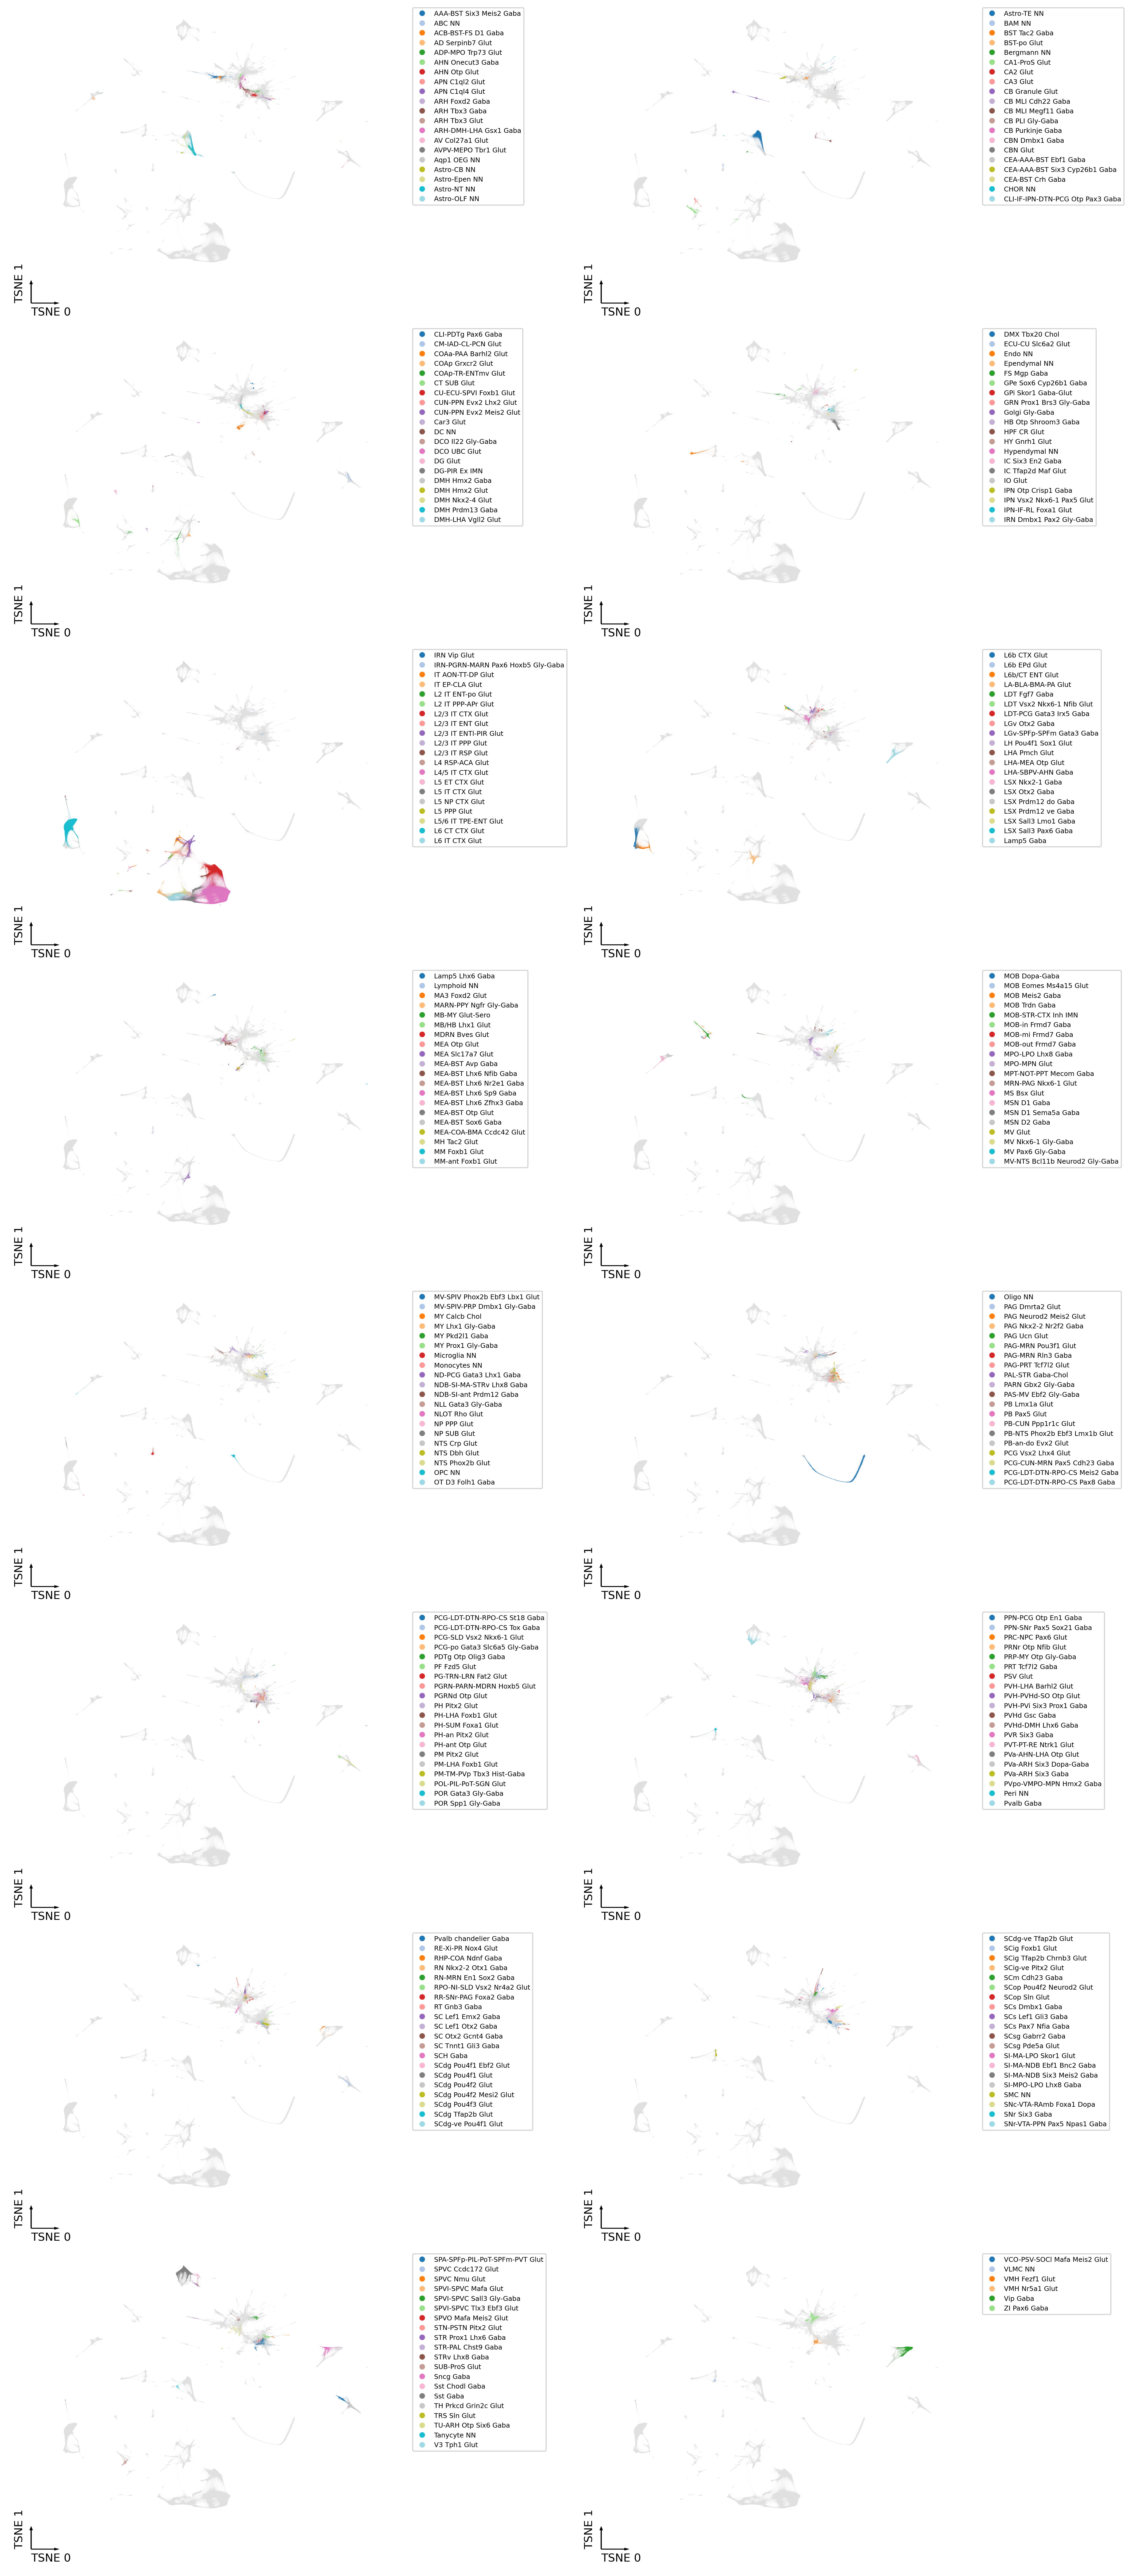

In [7]:
nplot = (count.shape[0] - 1) // 20 + 1
nrow = (nplot - 1) // 2 + 1
ncol = 2
tmp = adata_merge.obs.loc[adata_merge.obs['Study']=='AIBS_10x']
fig, axes = plt.subplots(nrow, ncol, figsize=(ncol * 7, nrow * 4), dpi=300, constrained_layout=True, sharex='all', sharey='all')
for i in range(nplot):
    legtmp = leg[(i * 20) : ((i + 1) * 20)]
    tmp0 = tmp.loc[tmp["L2_annot"].isin(legtmp)]
    ax = axes.flatten()[i]
    ax.scatter(
        adata_merge.obs[f"{coord_base}_0"],
        adata_merge.obs[f"{coord_base}_1"],
        c="#e0e0e0",
        edgecolors="none",
        s=ds,
        alpha=0.5,
        rasterized=True,
    )
    _ = categorical_scatter(
        data=tmp0,
        ax=ax,
        coord_base=coord_base,
        s=ds*4,
        hue="L2_annot",
        # text_anno='L2_annot',
        palette="tab20",
        labelsize=10,
        max_points=None,
        scatter_kws={"rasterized": True},
        show_legend=True,
        legend_kws={"ncol": 1, "fontsize": 6},
    )
if nrow * ncol > nplot:
    for i in range(nplot, nrow * ncol):
        axes.flatten()[i].axis("off")

ax.set_xlim(adata_merge.obs[f'{coord_base}_0'].min(), adata_merge.obs[f'{coord_base}_0'].max())
ax.set_ylim(adata_merge.obs[f'{coord_base}_1'].min(), adata_merge.obs[f'{coord_base}_1'].max())

# plt.savefig(f'cell_{adata_merge.shape[0]}_{t}_AIBS10x_CEMBAsnmC_CEMBAEpiRetro.AIBSL2.pdf', transparent=True)


In [5]:
# data = adata_merge.obs.loc[adata_merge.obs['Study']=='AIBS_10x', ['leiden', 'L3']].value_counts().unstack(fill_value=0)
data = adata_merge.obs.loc[~adata_merge.obs['leiden'].isna(), ['leiden', 'L3']].value_counts().unstack(fill_value=0)
rna_only_cluster = data.index[data['nan']==0]
data = data.drop(['nan'], axis=1)
merfish_only_cluster = data.index[data.sum(axis=1)==0]
data = data.drop(merfish_only_cluster, axis=0)
datac = data / data.sum(axis=0)
datar = data / data.sum(axis=1)[:,None]
confusion_matrix = datar.where(datar > datac, datac)
print(rna_only_cluster.tolist(), merfish_only_cluster.tolist())


['97', '98', '100', '101'] []


In [6]:
# confusion matrix contains RNA only clusters, but not merfish only clusters
if data.values.max()>0.1:
    (
        query_group,
        ref_group,
        confusion_matrix,
        g,
        modularity_score1,
    ) = confusion_matrix_clustering(
        confusion_matrix=confusion_matrix.T,
        min_value=0.1,
        max_value=0.9,
        partition_type=None,
        resolution=1.0,
        seed=0,
    )
else:
    ref_group = pd.Series(-1, index=data.index)
    query_group = pd.Series(-1, index=data.columns)
    confusion_matrix = confusion_matrix.T
    modularity_score1 = 0
    

In [7]:
print(modularity_score1, ref_group.unique().shape, query_group.unique().shape)

0.8930013374301276 (78,) (78,)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


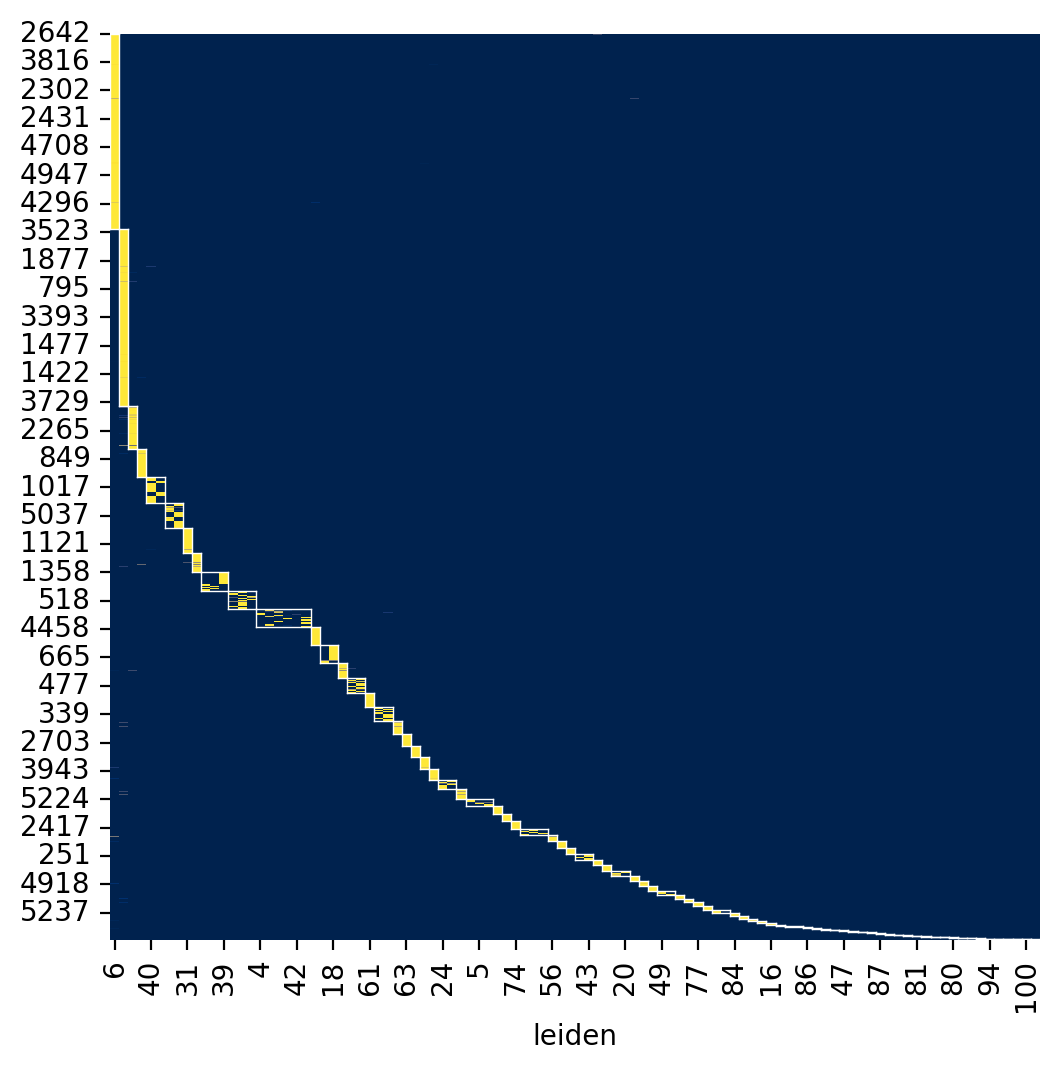

In [8]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=200)
sns.heatmap(confusion_matrix, ax=ax, vmin=0.1, vmax=0.9, cmap='cividis', cbar=None)
cumsum_c, cumsum_r = 0, 0
for xx in ref_group.sort_values().unique():
    rlen, clen = (query_group==xx).sum(), (ref_group==xx).sum()
    ax.plot([cumsum_c, cumsum_c + clen], [cumsum_r, cumsum_r], c='w', linewidth=0.5)
    ax.plot([cumsum_c, cumsum_c + clen], [cumsum_r + rlen, cumsum_r + rlen], c='w', linewidth=0.5)
    ax.plot([cumsum_c, cumsum_c], [cumsum_r, cumsum_r + rlen], c='w', linewidth=0.5)
    ax.plot([cumsum_c + clen, cumsum_c + clen], [cumsum_r, cumsum_r + rlen], c='w', linewidth=0.5)
    cumsum_c += clen
    cumsum_r += rlen
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(-20.738047245440743, 18.888916206531206)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


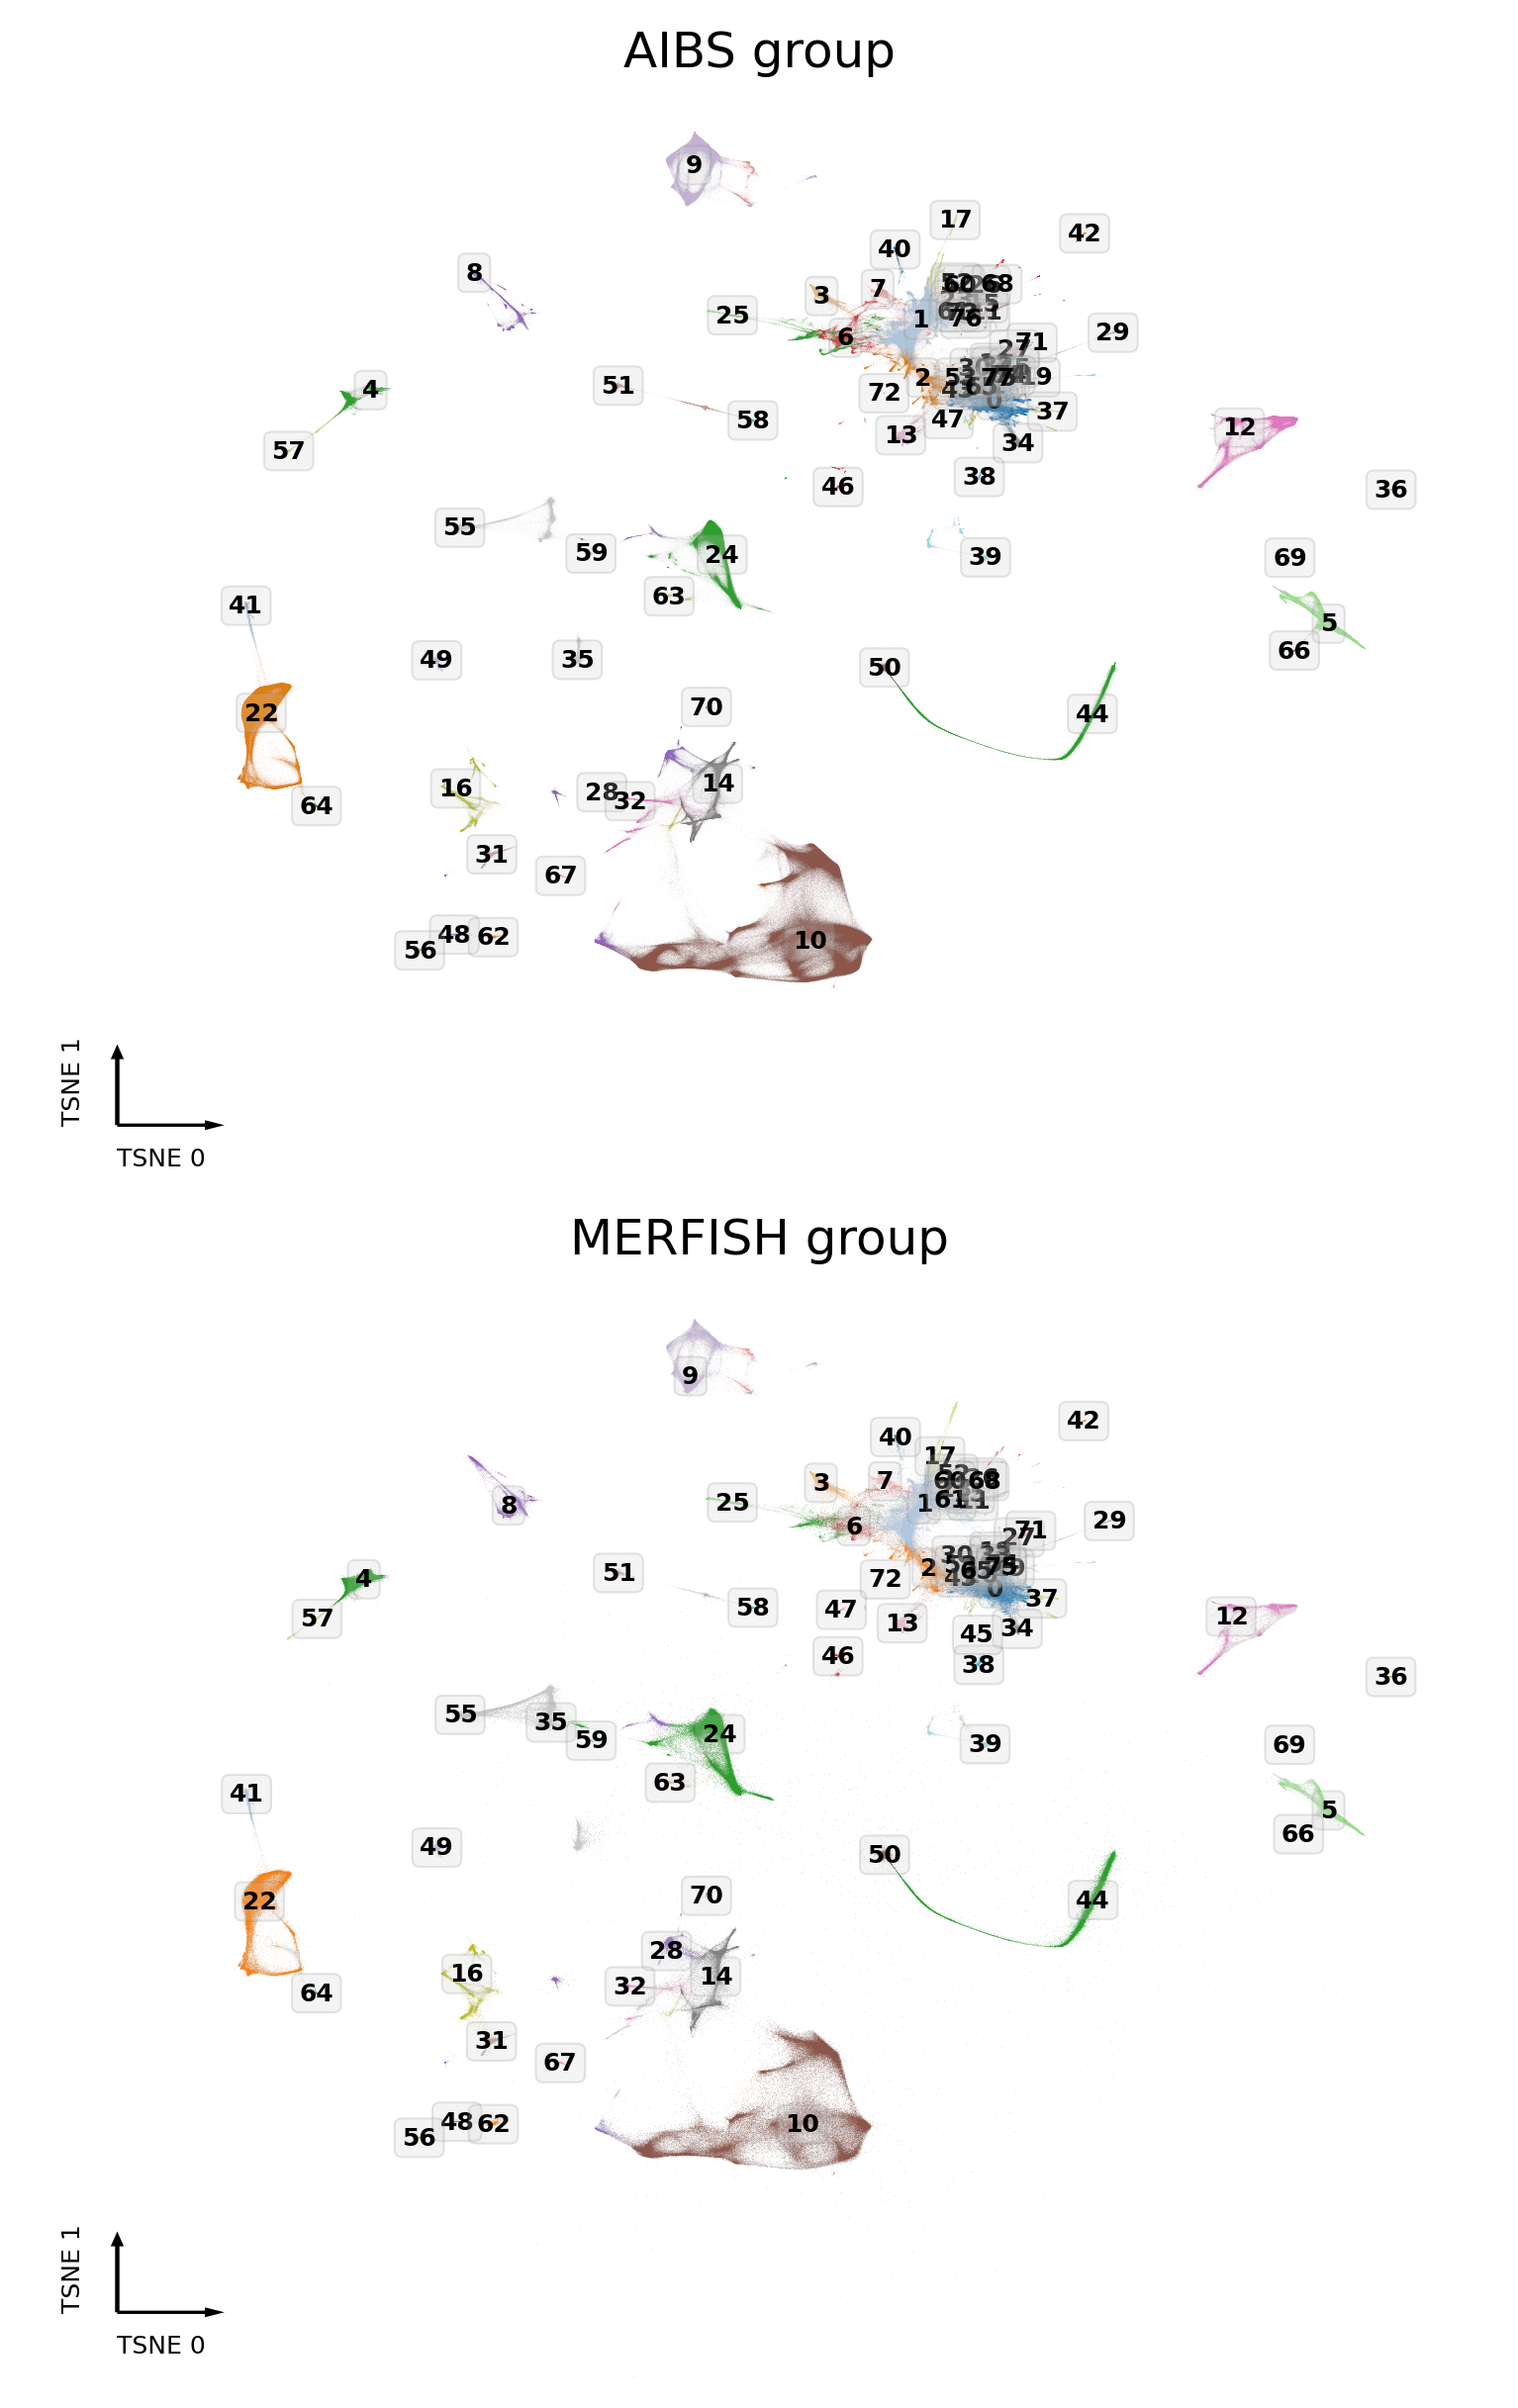

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(5, 8), dpi=300, constrained_layout=True, sharex='all', sharey='all')

group_map = ref_group.append(pd.Series(-1, index=merfish_only_cluster))
tmp = np.sort(pd.concat([group_map, query_group]).unique())
color_palette = {xx:yy for xx,yy in zip(tmp, sns.color_palette(palette='tab20', n_colors=len(tmp)))}

tmp = adata_merge.obs.loc[adata_merge.obs['Study']=='AIBS_10x']
tmp['int_group'] = tmp['L3'].map(query_group).astype(int)
ax = axes[0]
ax.scatter(adata_merge.obs[f'{coord_base}_0'], adata_merge.obs[f'{coord_base}_1'], c='#e0e0e0', edgecolors='none', s=ds, rasterized=True)
_ = categorical_scatter(data=tmp,
                        ax=ax,
                        coord_base=coord_base,
                        s=ds,
                        hue='int_group',
                        text_anno='int_group',
                        palette=color_palette,
                        labelsize=6,
                        max_points=None,
                        scatter_kws={'rasterized':True},
                        # show_legend=True,
                        # legend_kws={'ncol':1, "fontsize": 6},
                       )

tmp = adata_merge.obs.loc[adata_merge.obs['Study']=='MERFISH']
tmp['int_group'] = tmp['leiden'].map(group_map).astype(int)
## assign MERFISH only cluster to -1 otherwise will be NA
# tmp.loc[tmp['leiden'].isin(merfish_only_cluster), 'int_group'] = -1
# tmp['int_group'] = tmp['int_group'].astype(int)
ax = axes[1]
ax.scatter(adata_merge.obs[f'{coord_base}_0'], adata_merge.obs[f'{coord_base}_1'], c='#e0e0e0', edgecolors='none', s=ds, rasterized=True)
_ = categorical_scatter(data=tmp,
                        ax=ax,
                        coord_base=coord_base,
                        s=ds*r,
                        hue='int_group',
                        text_anno='int_group',
                        palette=color_palette,
                        labelsize=6,
                        max_points=None,
                        scatter_kws={'rasterized':True},
                        #show_legend=True,
                        #legend_kws={'ncol':1},
                       )

for i,xx in enumerate(['AIBS group', 'MERFISH group']):
    axes[i].set_title(xx, fontsize=12)

ax.set_xlim(adata_merge.obs[f'{coord_base}_0'].min(), adata_merge.obs[f'{coord_base}_0'].max())
ax.set_ylim(adata_merge.obs[f'{coord_base}_1'].min(), adata_merge.obs[f'{coord_base}_1'].max())


# plt.savefig(f'/gale/netapp/entex/CEMBA_RS2/RS1/plot/cell_{adata_merge.shape[0]}_Neu_10xAIBS2geneCH.pdf', transparent=True)


In [9]:
integration_group_cluster = {}
integration_group_cell = {}
for group,xx in ref_group.groupby(ref_group):
    ref_cluster = xx.index
    ## coclusters together contain 50% RNA cluster, or RNA cluster contains 10% of any coclusters
    qry_cluster = (datac.loc[ref_cluster].sum(axis=0) > 0.3) | (datar.loc[ref_cluster].max(axis=0) > 0.3)
    # qry_cluster = (datac.loc[group] > 0.3) | (datar.loc[group] > 0.3)
    qry_cluster = qry_cluster.index[qry_cluster].astype(str)
    # print(group, ref_cluster, qry_cluster)
    ref_cell = adata_merge.obs.index[(adata_merge.obs['Study']=='MERFISH') & (adata_merge.obs['leiden'].isin(ref_cluster))]
    qry_cell = adata_merge.obs.index[(adata_merge.obs['Study']=='AIBS_10x') & (adata_merge.obs['L3'].isin(qry_cluster))]
    if (len(qry_cell)>0) and (len(ref_cell)>0):
        ## integration_group is used for split coclusters into next iteration, so should have cells from both modalities
        ## qry_cell must already be positive since len(qry_cluster)>0 in the last condition, so this if requires the group to have MERFISH cells
        integration_group_cluster[group] = {
            "ref": ref_cluster.tolist(),
            "qry": qry_cluster.tolist()
        }
        integration_group_cell[f'{group_name}IG{group}'] = {
            "ref": ref_cell.tolist(),
            "qry": qry_cell.tolist()
        }
    else:
        print(group, ref_cluster, qry_cluster)

print(len(integration_group_cluster), len(integration_group_cell))


73 Index(['97'], dtype='object') Index(['4193'], dtype='object', name='L3')
74 Index(['98'], dtype='object') Index(['4327'], dtype='object', name='L3')
76 Index(['100'], dtype='object') Index(['3740'], dtype='object', name='L3')
77 Index(['101'], dtype='object') Index(['4104'], dtype='object', name='L3')
74 74


In [10]:
all_ref_clusters, all_qry_clusters = [], []
for group, group_dict in integration_group_cluster.items():
    if group!=-1:
        all_ref_clusters += group_dict['ref']
        all_qry_clusters += group_dict['qry']
    
all_ref_clusters = set(all_ref_clusters)
all_qry_clusters = set(all_qry_clusters)
print(len(all_ref_clusters), len(all_qry_clusters))


98 5204


In [1]:
# assign integration group
if (modularity_score1>=0.3) and ((adata_merge.obs['Study']=='AIBS_10x').sum()>=1000) and (data.shape[0]>1):
    outlier_rna_cell = adata_merge.obs.index[(~adata_merge.obs['L3'].isin(all_qry_clusters)) & (adata_merge.obs['Study']=='AIBS_10x')]
    outlier_merfish_cell = adata_merge.obs.index[(~adata_merge.obs['leiden'].isin(all_ref_clusters)) & (adata_merge.obs['Study']=='MERFISH')]
    if (len(outlier_rna_cell)>0) and (len(outlier_merfish_cell)>0):
        integration_group_cell[f'{group_name}IG-1'] = {'ref':outlier_merfish_cell, 'qry':outlier_rna_cell}
        # print(integration_group_cluster[-1])
    else:
        if len(outlier_merfish_cell)>0:
            pd.Series(outlier_merfish_cell).to_hdf('MERFISH_outlier.hdf', key='data')
            print(f'MERFISH outlier {len(outlier_merfish_cell)} cells')
        else:
            pd.Series(outlier_rna_cell).to_hdf('AIBS10x_outlier.hdf', key='data')
            print(f'AIBS outlier {len(outlier_rna_cell)} cells')
    joblib.dump(integration_group_cell, 'MERFISH-cocluster.AIBS10x-L4.integration_groups.dict')
    level = group_name.count('IG') + 1
    ref_adata = anndata.read_h5ad('aibs_10x.h5ad')
    qry_adata = anndata.read_h5ad('merfish.h5ad')
    for group in integration_group_cell:
        print(group, len(integration_group_cell[group]['ref']), len(integration_group_cell[group]['qry']))
        outdir = f'/home/jzhou_salk_edu/sky_workdir/230214_merfish_integration/L{level+1}/{group}/'
        os.makedirs(outdir, exist_ok=True)
        selc = integration_group_cell[group]['ref']
        tmp = qry_adata[selc].copy()
        tmp.write_h5ad(f'{outdir}merfish.h5ad')
        selc = integration_group_cell[group]['qry']
        tmp = ref_adata[selc].copy()
        tmp.write_h5ad(f'{outdir}aibs_10x.h5ad')    


In [12]:
aibs_cell = (adata_merge.obs['Study']=='AIBS_10x') & (adata_merge.obs['L3'].isin(all_qry_clusters))
merfish_cell = (adata_merge.obs['Study']=='MERFISH') & (adata_merge.obs['leiden'].isin(all_ref_clusters))
print(aibs_cell.sum(), merfish_cell.sum())

cluster = pd.DataFrame(-1, index=adata_merge.obs.index[adata_merge.obs['Study']=='MERFISH'], columns=[f'L{xx+1}{yy}' for xx in range(3) for yy in ['', '_score']])
# neighbor = pd.Series('NA', index=adata_merge.obs.index[adata_merge.obs['Study']=='AIBS_10x'])

chunk_size = 50000
if (aibs_cell.sum()>0) and (merfish_cell.sum()>0):
    # assign merfish cell to 10x clusters
    sd = 1
    start_time = time.time()
    index = pynndescent.NNDescent(adata_merge.obsm['X_pca_corrected'][aibs_cell], metric='euclidean', n_neighbors=min(50, aibs_cell.sum()), random_state=0, n_jobs=-1)
    print(time.time() - start_time)
    G, D = index.query(adata_merge.obsm['X_pca_corrected'][merfish_cell], k=min(25, aibs_cell.sum()))
    
    print(time.time() - start_time)
    cellfilter = (D[:,-1]==0)
    D = (1 - D/D[:,-1][:,None])
    D[cellfilter] = 1
    D = 1 - np.exp(-D*(sd**2)/4)
    D = D / (np.sum(D, axis=1) + 1e-6)[:,None]
    print(time.time() - start_time)
    
    enc = OneHotEncoder()
    # enc.fit(adata_merge.obs.loc[aibs_cell, ['L3']].values.astype(str))
    for i in range(3):
        labelref = enc.fit_transform(adata_merge.obs.loc[aibs_cell, [f'L{i+1}']].values.astype(str))
        for chunk_start in range(0, merfish_cell.sum(), chunk_size):
            result = (D[chunk_start : (chunk_start + chunk_size), :, None] * labelref[G[chunk_start : (chunk_start + chunk_size)].flatten()].toarray().reshape((-1, 25, enc.categories_[0].shape[0]))).sum(axis=1)
            result = pd.DataFrame(result, columns=enc.categories_[0], index=adata_merge.obs.index[merfish_cell][chunk_start : (chunk_start + chunk_size)])
            # result = (D[:,:,None] * labelref[G]).sum(axis=1)
            # result = pd.DataFrame(result, columns=enc.categories_[0], index=adata_merge.obs.index[merfish_cell])
            cluster.loc[result.index, f'L{i+1}'] = result.idxmax(axis=1).values
            cluster.loc[result.index, f'L{i+1}_score'] = result.max(axis=1).values
        print(time.time() - start_time)
    
cluster.to_hdf('MERFISH_AIBS10xcluster.hdf', key='data')
# neighbor.to_hdf('AIBS10x_closestMERFISHcell.hdf', key='data')


4065120 613096
968.5178914070129
2408.4848453998566
2408.6629242897034
2434.814080953598
2482.146363735199
3007.725601196289
130.86723232269287


In [2]:
aibs_cell = (adata_merge.obs['Study']=='AIBS_10x') & (adata_merge.obs['L3'].isin(all_qry_clusters))
merfish_cell = (adata_merge.obs['Study']=='MERFISH') & (adata_merge.obs['leiden'].isin(all_ref_clusters))
print(aibs_cell.sum(), merfish_cell.sum())

cluster = pd.DataFrame(-1, index=adata_merge.obs.index[adata_merge.obs['Study']=='MERFISH'], columns=[f'L{xx+1}{yy}' for xx in range(3) for yy in ['', '_score']])
# neighbor = pd.Series('NA', index=adata_merge.obs.index[adata_merge.obs['Study']=='AIBS_10x'])

chunk_size = 50000
if (aibs_cell.sum()>0) and (merfish_cell.sum()>0):
    # assign merfish cell to 10x clusters
    sd = 1
    start_time = time.time()
    index = pynndescent.NNDescent(adata_merge.obsm['X_pca_corrected'][aibs_cell], metric='euclidean', n_neighbors=min(50, aibs_cell.sum()), random_state=0, n_jobs=-1)
    print(time.time() - start_time)
    G, D = index.query(adata_merge.obsm['X_pca_corrected'][merfish_cell], k=min(25, aibs_cell.sum()))
    print(time.time() - start_time)
    np.savez('MERFISH_AIBS10xNN.npz', G=G, D=D, aibs_cell=adata_merge.obs.index[aibs_cell], merfish_cell=adata_merge.obs.index[merfish_cell])
    cellfilter = (D[:,-1]==0)
    D = (1 - D/D[:,-1][:,None])
    D[cellfilter] = 1
    D = 1 - np.exp(-D*(sd**2)/4)
    D = D / (np.sum(D, axis=1) + 1e-6)[:,None]
    print(time.time() - start_time)
    enc = OneHotEncoder()
    # enc.fit(adata_merge.obs.loc[aibs_cell, ['L3']].values.astype(str))
    for i in range(3):
        labelref = enc.fit_transform(adata_merge.obs.loc[aibs_cell, [f'L{i+1}']].values.astype(str))
        for chunk_start in range(0, merfish_cell.sum(), chunk_size):
            result = (D[chunk_start : (chunk_start + chunk_size), :, None] * labelref[G[chunk_start : (chunk_start + chunk_size)].flatten()].toarray().reshape((-1, min(25, aibs_cell.sum()), enc.categories_[0].shape[0]))).sum(axis=1)
            result = pd.DataFrame(result, columns=enc.categories_[0], index=adata_merge.obs.index[merfish_cell][chunk_start : (chunk_start + chunk_size)])
            # result = (D[:,:,None] * labelref[G]).sum(axis=1)
            # result = pd.DataFrame(result, columns=enc.categories_[0], index=adata_merge.obs.index[merfish_cell])
            cluster.loc[result.index, f'L{i+1}'] = result.idxmax(axis=1).values
            cluster.loc[result.index, f'L{i+1}_score'] = result.max(axis=1).values
        print(time.time() - start_time)
    # assign 10x cell to nearest merfish cell
    # start_time = time.time()
    # index = pynndescent.NNDescent(adata_merge.obsm['X_pca_corrected'][merfish_cell], metric='euclidean', n_neighbors=min(5, merfish_cell.sum()), random_state=0, n_jobs=-1)
    # print(time.time() - start_time)
    # G, D = index.query(adata_merge.obsm['X_pca_corrected'][aibs_cell], k=1)
    # neighbor.loc[adata_merge.obs.index[aibs_cell]] = adata_merge.obs.index[merfish_cell][G[:,0]].values

cluster.to_hdf('MERFISH_AIBS10xcluster.hdf', key='data')
# neighbor.to_hdf('AIBS10x_closestMERFISHcell.hdf', key='data')
